Created dataset with 1777 samples, Skipped intervals: [160°, 200°], for digit=4.


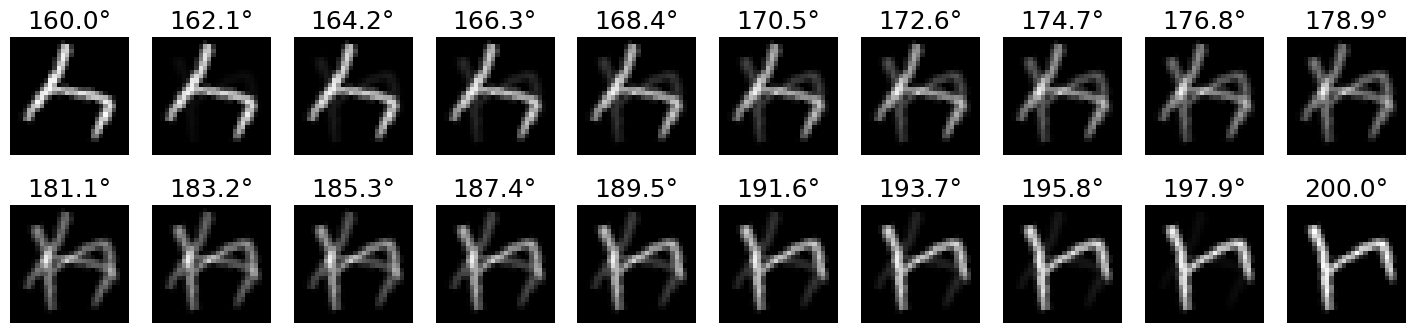

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from torchvision import datasets, transforms

# ------------------------------------------------
# 1) Define (or import) the dataset class
# ------------------------------------------------
class MultiIntervalRotatedMNISTDataset(torch.utils.data.Dataset):
    """
    Creates a dataset for a specific MNIST digit, skipping multiple angle intervals.

    'skip_intervals' is a list of (start_deg, end_deg) in degrees.
    Angles in ANY of those intervals are excluded from the dataset.
    """

    def __init__(
        self,
        num_samples=1000,
        digit=4,
        skip_intervals=[(100, 200)]
    ):
        super().__init__()
        # Load MNIST
        mnist = datasets.MNIST(
            './data',
            train=True,
            download=True,
            transform=transforms.ToTensor()
        )
        # Find the first instance of the chosen digit
        digit_indices = (mnist.targets == digit).nonzero().squeeze()
        self.original_image = mnist.data[digit_indices[0]].float() / 255.0

        self.skip_intervals = skip_intervals

        # Convert skip intervals to radians
        skip_rad_intervals = []
        for (start_deg, end_deg) in skip_intervals:
            start_r = start_deg * np.pi / 180.0
            end_r = end_deg * np.pi / 180.0
            skip_rad_intervals.append((start_r, end_r))

        # We'll create angles from 0..2π, skip any that fall in skip_intervals
        angles_full = np.linspace(0, 2*np.pi, num_samples, endpoint=False)

        def in_skip(a):
            for (sr, er) in skip_rad_intervals:
                if sr <= a <= er:
                    return True
            return False

        self.angles = [a for a in angles_full if not in_skip(a)]
        self.angles = np.array(self.angles, dtype=np.float32)
        self.num_samples = len(self.angles)

        # Precompute rotated images
        self.rotated_images = []
        for angle_rad in self.angles:
            angle_deg = angle_rad * 180.0 / np.pi
            rotated_img = rotate(
                self.original_image.numpy(),
                angle_deg,
                reshape=False,
                order=1,
                mode='constant',
                cval=0.0
            )
            self.rotated_images.append(torch.tensor(rotated_img, dtype=torch.float32))

        msg = "Skipped intervals: " + \
            ", ".join([f"[{s}°, {e}°]" for (s, e) in skip_intervals])
        print(
            f"Created dataset with {self.num_samples} samples, {msg}, for digit={digit}."
        )

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        angle_rad = self.angles[idx]
        angle_sin = np.sin(angle_rad)
        angle_cos = np.cos(angle_rad)
        return (
            torch.tensor([angle_cos, angle_sin], dtype=torch.float32),
            self.rotated_images[idx].unsqueeze(0)
        )

# ------------------------------------------------
# 2) Instantiate the dataset (MNIST digit = 4, skipping [160°,200°])
# ------------------------------------------------
dataset = MultiIntervalRotatedMNISTDataset(
    num_samples=2000, 
    digit=4, 
    skip_intervals=[(160, 200)]
)

# ------------------------------------------------
# 3) Manually rotate the original digit at 160° and 200°
# ------------------------------------------------
original_img = dataset.original_image.numpy()  # shape [28, 28], float in [0,1]

img_160 = rotate(original_img, 160, reshape=False, order=1, mode='constant', cval=0.0)
img_200 = rotate(original_img, 200, reshape=False, order=1, mode='constant', cval=0.0)

# Convert to float32 arrays (optional consistency)
img_160 = img_160.astype(np.float32)
img_200 = img_200.astype(np.float32)

# ------------------------------------------------
# 4) Interpolate pixelwise between 160° and 200°
#    We'll produce 20 images (including 0% and 100%)
# ------------------------------------------------
n_interps = 20
alphas = np.linspace(0.0, 1.0, n_interps)  # [0, 1] => 20 points

interp_images = []
for alpha in alphas:
    # Linear interpolation in pixel space
    img_alpha = (1 - alpha) * img_160 + alpha * img_200
    interp_images.append(img_alpha)

# ------------------------------------------------
# 5) Visualize the interpolated images in 2 rows, 10 columns
# ------------------------------------------------
fig, axes = plt.subplots(2, 10, figsize=(18, 4))

for i, alpha in enumerate(alphas):
    # Determine row and column indices
    row = i // 10
    col = i % 10

    ax = axes[row, col]
    ax.imshow(interp_images[i], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

    # Interpolated angle (for display only):
    #  - total angle difference: 200 - 160 = 40 degrees
    #  - alpha=0 => 160°, alpha=1 => 200°
    interp_angle = 160 + alpha * 40
    ax.set_title(f"{interp_angle:.1f}°", fontsize=18)

# plt.tight_layout()
# plt.show()
    plt.savefig('../icml_figs/interpolated_rotated_images_actual.pdf', bbox_inches='tight')


#  """Evaluate model's performance specifically in the gap region"""
#     model.eval()
#     with torch.no_grad():
#         # Generate angles specifically in the gap region
#         gap_angles = torch.linspace(160*np.pi/180, 200*np.pi/180, num_points, device=device)
#         inputs = torch.stack([torch.cos(gap_angles), torch.sin(gap_angles)], dim=1)
#         outputs = model(inputs)
        
#         plt.figure(figsize=(18, 4))
#         for i in range(num_points):
#             plt.subplot(2, num_points//2, i+1)
#             plt.imshow(outputs[i, 0].cpu().detach().numpy(), cmap='gray')
#             angle_deg = gap_angles[i].item() * 180 / np.pi
#             plt.title(f'{angle_deg:.1f}°', color='red',fontsize=18)
#             plt.axis('off')
#         # plt.suptitle('Interpolated Results in Gap Region (160° - 200°)', color='red')
#         # plt.tight_layout()
#         if store:
#             plt.savefig('../icml_figs/interpolated_rotated_images_a.pdf', bbox_inches='tight')
#         else:
#             plt.show()
